In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.functional as F

import torchvision #數據庫

import matplotlib.pyplot as plt

import os

torch.manual_seed(1)
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

config = {
    "epoch":5,
    "batch_size":50,
    "LR":0.001,
    "DOWNLOAD_MNIST": False if os.path.exists('../mnist') else True,
    "INPUT_SIZE" : 28,
    "TIME_STEP":28
}

In [2]:
# 載入資料

train_data = torchvision.datasets.MNIST(
    root='../mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(), # 值 0 ～ 1
    download=config["DOWNLOAD_MNIST"]
)

test_data = torchvision.datasets.MNIST(
    root='../mnist',
    train=False,
)

In [3]:
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2
)

In [4]:
# shape (2000, 28, 28) value in range(0,1)
# value in range(0,1) 
test_x = test_data.test_data.type(torch.FloatTensor)

test_x /= 255. # normalize

test_y = test_data.test_labels

test_x.size(),test_y.size()

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [5]:
# RNN

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        
        '''
        batch_first -> True  (batch,time_step,input_size)
                    -> False (time_step,batch,input_size)
        '''
        self.lstm_layer = nn.LSTM(
            input_size = config["INPUT_SIZE"],
            hidden_size = 64,
            num_layers = 1, 
            batch_first=True,
        )
        
        self.output_layer = nn.Linear(
            in_features=64,
            out_features=10
        )
        
    def forward(self,x):
        '''
        LSTM:
            Input: 
                 input:
                 h_0 : initial hidden state for each element, default 0
                 c_0 : initial cell state for each element, default 0
                 
            Output:
                output: output features (h_t) from the "last layer" of the LSTM,for each time
                h_n: hidden state for t = seq_len.
                c_n: the cell state for t = seq_len
        '''
        lstm_output,(h_n,h_c) = self.lstm_layer(x,None)
        
        out = self.output_layer(lstm_output[:,-1,:]) # get last time step
                                                     # (batch,time step,input)
        return out
        
        

In [6]:
model = LSTM().to(device)

print(model)

LSTM(
  (lstm_layer): LSTM(28, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
def draw_loss(loss_history):
    
    plt.plot(loss_history,label="loss",linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 3))
    plt.show()

In [8]:
def train(model,data_loader):
    l_h = []
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(),lr=config["LR"])
    loss_fun = nn.CrossEntropyLoss()
    
    for epoch in range(config['epoch']):
        for step,(b_x,b_y) in enumerate(data_loader):
            
            b_x,b_y = b_x.view(-1,28,28).to(device), b_y.to(device) # reshape x to (batch, time_step, input_size)

             
            optimizer.zero_grad()      
            
            output = model(b_x)
            
            loss = loss_fun(output,b_y)
            
            
            
            loss.backward()
            optimizer.step()
            
            l_h.append(loss.item()) 

            if step % 200 == 0:
                
                print('Epoch: ', epoch, '| step ',step,'| train loss: %.4f' % loss.item())
                
                
            
    draw_loss(l_h)


Epoch:  0 | step  0 | train loss: 2.2841
Epoch:  0 | step  200 | train loss: 0.9274
Epoch:  0 | step  400 | train loss: 0.5716
Epoch:  0 | step  600 | train loss: 0.3711
Epoch:  0 | step  800 | train loss: 0.1801
Epoch:  0 | step  1000 | train loss: 0.1581
Epoch:  1 | step  0 | train loss: 0.2363
Epoch:  1 | step  200 | train loss: 0.1291
Epoch:  1 | step  400 | train loss: 0.1885
Epoch:  1 | step  600 | train loss: 0.0754
Epoch:  1 | step  800 | train loss: 0.2013
Epoch:  1 | step  1000 | train loss: 0.0726
Epoch:  2 | step  0 | train loss: 0.0191
Epoch:  2 | step  200 | train loss: 0.0942
Epoch:  2 | step  400 | train loss: 0.0705
Epoch:  2 | step  600 | train loss: 0.0644
Epoch:  2 | step  800 | train loss: 0.0393
Epoch:  2 | step  1000 | train loss: 0.0184
Epoch:  3 | step  0 | train loss: 0.0137
Epoch:  3 | step  200 | train loss: 0.0601
Epoch:  3 | step  400 | train loss: 0.1280
Epoch:  3 | step  600 | train loss: 0.1481
Epoch:  3 | step  800 | train loss: 0.0740
Epoch:  3 | step

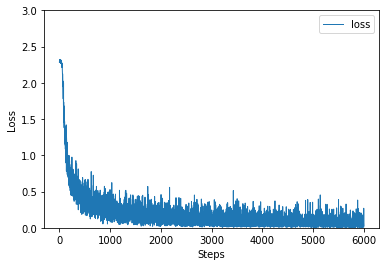

In [9]:
train(model,data_loader=train_loader)

In [10]:
def test(model,test_x,test_y):
    model.eval()
    
    with torch.no_grad():
        test_x,test_y = test_x.to(device),test_y.to(device)                                                   
        output = model(test_x)
        predit = torch.max(output, 1)[1]
        accuracy = torch.sum(predit==test_y).type(torch.FloatTensor)/test_y.size(0)
        
        print(accuracy.item())

In [11]:
test(model,test_x,test_y)

0.9772999882698059
